In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ---------------------------------------
# 1. Data Loading and Inspection
# ---------------------------------------
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')

print("Training Data Sample:\n", train_data.head())
print("Test Data Sample:\n", test_data.head())
print("Missing values in training data:\n", train_data.isnull().sum())

Training Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Missing values in training data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# ---------------------------------------
# 2. Data Cleaning and Preprocessing
# ---------------------------------------
features = ['Open', 'High', 'Low', 'Close']

# Convert columns that are object type with commas into float
for feature in features:
    if train_data[feature].dtype == 'object':
        train_data[feature] = train_data[feature].str.replace(',', '', regex=True).astype(float)
    if test_data[feature].dtype == 'object':
        test_data[feature] = test_data[feature].str.replace(',', '', regex=True).astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [ ]:
# ---------------------------------------
# 3. Fixed-length Sequence Creation (Sliding Window)
# ---------------------------------------
N = 30  # number of past days used as input
M = 1   # number of future days to predict

X, y = [], []
for i in range(N, len(training_set_scaled) - M + 1):
    X.append(training_set_scaled[i-N:i, :])
    y.append(training_set_scaled[i:i+M, :])

X, y = np.array(X), np.array(y)

# Split into training and validation sets (time-aware)
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [ ]:
# ---------------------------------------
# 4. Dataset and DataLoader
# ---------------------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# ---------------------------------------
# 5. GRU Model Definition
# ---------------------------------------
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [B, T, input_dim]
        out, _ = self.gru(x)  # out: [B, T, hidden_dim]
        out = out[:, -1, :]    # Take the last time step
        out = self.fc(out)     # Map to output_dim
        return out

In [ ]:
# ---------------------------------------
# 6. Custom Asymmetric Loss Function
# ---------------------------------------
class AsymmetricLoss(nn.Module):
    def __init__(self, ratio=2.0):
        super(AsymmetricLoss, self).__init__()
        self.ratio = ratio

    def forward(self, pred, target):
        diff = target - pred
        loss = torch.mean(torch.where(diff > 0, self.ratio * diff**2, diff**2))
        return loss

In [ ]:
# ---------------------------------------
# 7. Training Function with Metric Logging
# ---------------------------------------
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(outputs.shape))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(outputs.shape))
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_state, best_val_loss, train_losses, val_losses

In [ ]:
# ---------------------------------------
# 8. Hyperparameter Tuning with Optuna
# ---------------------------------------
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 20, 100)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    ratio = trial.suggest_float('asymmetric_ratio', 1.0, 5.0)

    model = GRUModel(input_dim=len(features), hidden_dim=hidden_dim, output_dim=len(features)).to(device)
    criterion = AsymmetricLoss(ratio=ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    # Shorter training for tuning
    best_state, best_val_loss, _, _ = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 21:53:27,881] A new study created in memory with name: no-name-6fc4b867-5934-49f8-8d9d-cecce17b4385


Epoch 1/30, Train Loss: 0.0292, Val Loss: 0.0585
Epoch 2/30, Train Loss: 0.0754, Val Loss: 0.0089
Epoch 3/30, Train Loss: 0.0573, Val Loss: 0.0181
Epoch 4/30, Train Loss: 0.0257, Val Loss: 0.0050
Epoch 5/30, Train Loss: 0.0169, Val Loss: 0.0073
Epoch 6/30, Train Loss: 0.0113, Val Loss: 0.0087
Epoch 7/30, Train Loss: 0.0029, Val Loss: 0.0012
Epoch 8/30, Train Loss: 0.0029, Val Loss: 0.0014
Epoch 9/30, Train Loss: 0.0010, Val Loss: 0.0008
Epoch 10/30, Train Loss: 0.0015, Val Loss: 0.0006
Epoch 11/30, Train Loss: 0.0021, Val Loss: 0.0012
Epoch 12/30, Train Loss: 0.0047, Val Loss: 0.0047
Epoch 13/30, Train Loss: 0.0068, Val Loss: 0.0030
Epoch 14/30, Train Loss: 0.0115, Val Loss: 0.0041
Epoch 15/30, Train Loss: 0.0122, Val Loss: 0.0140
Epoch 16/30, Train Loss: 0.0015, Val Loss: 0.0028
Epoch 17/30, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0009
Epoch 19/30, Train Loss: 0.0006, Val Loss: 0.0008
Epoch 20/30, Train Loss: 0.0006, Val Loss: 0.0008
Epoch 21/

[I 2024-12-06 21:53:58,646] Trial 0 finished with value: 0.0006294366794463713 and parameters: {'hidden_dim': 68, 'lr': 0.003345478222762629, 'weight_decay': 2.2322873487072344e-06, 'asymmetric_ratio': 2.199319361712599}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0008
Epoch 1/30, Train Loss: 0.3463, Val Loss: 0.9436
Epoch 2/30, Train Loss: 0.0868, Val Loss: 0.2719
Epoch 3/30, Train Loss: 0.0704, Val Loss: 0.1668
Epoch 4/30, Train Loss: 0.0692, Val Loss: 0.1670
Epoch 5/30, Train Loss: 0.0629, Val Loss: 0.1493
Epoch 6/30, Train Loss: 0.0579, Val Loss: 0.1320
Epoch 7/30, Train Loss: 0.0529, Val Loss: 0.1152
Epoch 8/30, Train Loss: 0.0479, Val Loss: 0.0993
Epoch 9/30, Train Loss: 0.0430, Val Loss: 0.0845
Epoch 10/30, Train Loss: 0.0384, Val Loss: 0.0713
Epoch 11/30, Train Loss: 0.0342, Val Loss: 0.0603
Epoch 12/30, Train Loss: 0.0307, Val Loss: 0.0514
Epoch 13/30, Train Loss: 0.0279, Val Loss: 0.0440
Epoch 14/30, Train Loss: 0.0253, Val Loss: 0.0375
Epoch 15/30, Train Loss: 0.0226, Val Loss: 0.0313
Epoch 16/30, Train Loss: 0.0197, Val Loss: 0.0249
Epoch 17/30, Train Loss: 0.0163, Val Loss: 0.0179
Epoch 18/30, Train Loss: 0.0123, Val Loss: 0.0102
Epoch 19/30, Train Loss: 0.0077, Val Loss: 0.0033
Epoch 20/

[I 2024-12-06 21:54:11,895] Trial 1 finished with value: 0.0009885558756650425 and parameters: {'hidden_dim': 22, 'lr': 0.0008427054578291351, 'weight_decay': 6.170889635199587e-05, 'asymmetric_ratio': 4.412229034819468}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 1/30, Train Loss: 0.2231, Val Loss: 0.6813
Epoch 2/30, Train Loss: 0.1886, Val Loss: 0.5980
Epoch 3/30, Train Loss: 0.1597, Val Loss: 0.5205
Epoch 4/30, Train Loss: 0.1333, Val Loss: 0.4446
Epoch 5/30, Train Loss: 0.1087, Val Loss: 0.3690
Epoch 6/30, Train Loss: 0.0863, Val Loss: 0.2948
Epoch 7/30, Train Loss: 0.0674, Val Loss: 0.2264
Epoch 8/30, Train Loss: 0.0535, Val Loss: 0.1698
Epoch 9/30, Train Loss: 0.0456, Val Loss: 0.1298
Epoch 10/30, Train Loss: 0.0422, Val Loss: 0.1057
Epoch 11/30, Train Loss: 0.0407, Val Loss: 0.0923
Epoch 12/30, Train Loss: 0.0397, Val Loss: 0.0843
Epoch 13/30, Train Loss: 0.0386, Val Loss: 0.0788
Epoch 14/30, Train Loss: 0.0374, Val Loss: 0.0742
Epoch 15/30, Train Loss: 0.0362, Val Loss: 0.0700
Epoch 16/30, Train Loss: 0.0350, Val Loss: 0.0660
Epoch 17/30, Train Loss: 0.0339, Val Loss: 0.0622
Epoch 18/30, Train Loss: 0.0327, Val Loss: 0.0585
Epoch 19/30, Train Loss: 0.0315, Val Loss: 0.0548
Epoch 20/

[I 2024-12-06 21:54:26,954] Trial 2 finished with value: 0.01896424894221127 and parameters: {'hidden_dim': 42, 'lr': 0.00011591253315713278, 'weight_decay': 2.6900705256756998e-06, 'asymmetric_ratio': 1.441192657002342}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0187, Val Loss: 0.0190
Epoch 1/30, Train Loss: 0.0390, Val Loss: 0.0356
Epoch 2/30, Train Loss: 0.0555, Val Loss: 0.0207
Epoch 3/30, Train Loss: 0.0626, Val Loss: 0.0095
Epoch 4/30, Train Loss: 0.0635, Val Loss: 0.0159
Epoch 5/30, Train Loss: 0.0333, Val Loss: 0.0119
Epoch 6/30, Train Loss: 0.0263, Val Loss: 0.0174
Epoch 7/30, Train Loss: 0.0174, Val Loss: 0.0143
Epoch 8/30, Train Loss: 0.0149, Val Loss: 0.0152
Epoch 9/30, Train Loss: 0.0052, Val Loss: 0.0057
Epoch 10/30, Train Loss: 0.0026, Val Loss: 0.0028
Epoch 11/30, Train Loss: 0.0016, Val Loss: 0.0020
Epoch 12/30, Train Loss: 0.0012, Val Loss: 0.0019
Epoch 13/30, Train Loss: 0.0011, Val Loss: 0.0018
Epoch 14/30, Train Loss: 0.0010, Val Loss: 0.0016
Epoch 15/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 16/30, Train Loss: 0.0010, Val Loss: 0.0014
Epoch 17/30, Train Loss: 0.0009, Val Loss: 0.0013
Epoch 18/30, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 19/30, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 20/

[I 2024-12-06 21:54:49,234] Trial 3 finished with value: 0.000913049476366723 and parameters: {'hidden_dim': 65, 'lr': 0.004982847014607971, 'weight_decay': 5.0712927136195065e-05, 'asymmetric_ratio': 4.371374001803243}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0009, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.0348, Val Loss: 0.0459
Epoch 2/30, Train Loss: 0.0676, Val Loss: 0.0115
Epoch 3/30, Train Loss: 0.0690, Val Loss: 0.0050
Epoch 4/30, Train Loss: 0.0465, Val Loss: 0.0053
Epoch 5/30, Train Loss: 0.0322, Val Loss: 0.0091
Epoch 6/30, Train Loss: 0.0251, Val Loss: 0.0213
Epoch 7/30, Train Loss: 0.0078, Val Loss: 0.0033
Epoch 8/30, Train Loss: 0.0145, Val Loss: 0.0068
Epoch 9/30, Train Loss: 0.0028, Val Loss: 0.0014
Epoch 10/30, Train Loss: 0.0123, Val Loss: 0.0066
Epoch 11/30, Train Loss: 0.0016, Val Loss: 0.0020
Epoch 12/30, Train Loss: 0.0035, Val Loss: 0.0016
Epoch 13/30, Train Loss: 0.0032, Val Loss: 0.0025
Epoch 14/30, Train Loss: 0.0053, Val Loss: 0.0046
Epoch 15/30, Train Loss: 0.0031, Val Loss: 0.0074
Epoch 16/30, Train Loss: 0.0020, Val Loss: 0.0052
Epoch 17/30, Train Loss: 0.0016, Val Loss: 0.0037
Epoch 18/30, Train Loss: 0.0013, Val Loss: 0.0036
Epoch 19/30, Train Loss: 0.0013, Val Loss: 0.0035
Epoch 20/

[I 2024-12-06 21:55:05,411] Trial 4 finished with value: 0.001354374791844748 and parameters: {'hidden_dim': 57, 'lr': 0.005082409941105347, 'weight_decay': 0.0002762100296067968, 'asymmetric_ratio': 2.980294443847058}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0012, Val Loss: 0.0033
Epoch 1/30, Train Loss: 0.1399, Val Loss: 0.0376
Epoch 2/30, Train Loss: 0.1017, Val Loss: 0.0734
Epoch 3/30, Train Loss: 0.0627, Val Loss: 0.0566
Epoch 4/30, Train Loss: 0.0459, Val Loss: 0.0413
Epoch 5/30, Train Loss: 0.0313, Val Loss: 0.0218
Epoch 6/30, Train Loss: 0.0207, Val Loss: 0.0088
Epoch 7/30, Train Loss: 0.0118, Val Loss: 0.0010
Epoch 8/30, Train Loss: 0.0049, Val Loss: 0.0018
Epoch 9/30, Train Loss: 0.0063, Val Loss: 0.0064
Epoch 10/30, Train Loss: 0.0027, Val Loss: 0.0019
Epoch 11/30, Train Loss: 0.0025, Val Loss: 0.0015
Epoch 12/30, Train Loss: 0.0017, Val Loss: 0.0011
Epoch 13/30, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 14/30, Train Loss: 0.0013, Val Loss: 0.0010
Epoch 15/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 16/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 17/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 18/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 19/30, Train Loss: 0.0012, Val Loss: 0.0010
Epoch 20/

[I 2024-12-06 21:55:26,078] Trial 5 finished with value: 0.0009175584782497026 and parameters: {'hidden_dim': 82, 'lr': 0.0008976925069013959, 'weight_decay': 7.81615029070899e-06, 'asymmetric_ratio': 3.5591576300447447}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.6324, Val Loss: 1.8438
Epoch 2/30, Train Loss: 0.5179, Val Loss: 1.5703
Epoch 3/30, Train Loss: 0.4256, Val Loss: 1.3285
Epoch 4/30, Train Loss: 0.3439, Val Loss: 1.1031
Epoch 5/30, Train Loss: 0.2696, Val Loss: 0.8883
Epoch 6/30, Train Loss: 0.2028, Val Loss: 0.6853
Epoch 7/30, Train Loss: 0.1459, Val Loss: 0.5014
Epoch 8/30, Train Loss: 0.1028, Val Loss: 0.3493
Epoch 9/30, Train Loss: 0.0760, Val Loss: 0.2415
Epoch 10/30, Train Loss: 0.0628, Val Loss: 0.1763
Epoch 11/30, Train Loss: 0.0573, Val Loss: 0.1418
Epoch 12/30, Train Loss: 0.0548, Val Loss: 0.1244
Epoch 13/30, Train Loss: 0.0532, Val Loss: 0.1151
Epoch 14/30, Train Loss: 0.0520, Val Loss: 0.1092
Epoch 15/30, Train Loss: 0.0508, Val Loss: 0.1050
Epoch 16/30, Train Loss: 0.0497, Val Loss: 0.1016
Epoch 17/30, Train Loss: 0.0487, Val Loss: 0.0985
Epoch 18/30, Train Loss: 0.0476, Val Loss: 0.0957
Epoch 19/30, Train Loss: 0.0466, Val Loss: 0.0930
Epoch 20/

[I 2024-12-06 21:55:41,436] Trial 6 finished with value: 0.06465097330510616 and parameters: {'hidden_dim': 51, 'lr': 0.00010045327155806452, 'weight_decay': 0.0002978421628551044, 'asymmetric_ratio': 3.2179421962630737}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0360, Val Loss: 0.0647
Epoch 1/30, Train Loss: 0.7006, Val Loss: 2.2205
Epoch 2/30, Train Loss: 0.5170, Val Loss: 1.7592
Epoch 3/30, Train Loss: 0.3705, Val Loss: 1.3325
Epoch 4/30, Train Loss: 0.2407, Val Loss: 0.9161
Epoch 5/30, Train Loss: 0.1365, Val Loss: 0.5434
Epoch 6/30, Train Loss: 0.0792, Val Loss: 0.2951
Epoch 7/30, Train Loss: 0.0675, Val Loss: 0.1962
Epoch 8/30, Train Loss: 0.0674, Val Loss: 0.1691
Epoch 9/30, Train Loss: 0.0661, Val Loss: 0.1586
Epoch 10/30, Train Loss: 0.0641, Val Loss: 0.1504
Epoch 11/30, Train Loss: 0.0620, Val Loss: 0.1423
Epoch 12/30, Train Loss: 0.0599, Val Loss: 0.1342
Epoch 13/30, Train Loss: 0.0579, Val Loss: 0.1263
Epoch 14/30, Train Loss: 0.0558, Val Loss: 0.1185
Epoch 15/30, Train Loss: 0.0537, Val Loss: 0.1107
Epoch 16/30, Train Loss: 0.0517, Val Loss: 0.1030
Epoch 17/30, Train Loss: 0.0496, Val Loss: 0.0953
Epoch 18/30, Train Loss: 0.0475, Val Loss: 0.0875
Epoch 19/30, Train Loss: 0.0454, Val Loss: 0.0798
Epoch 20/

[I 2024-12-06 21:55:57,136] Trial 7 finished with value: 0.009008010034449399 and parameters: {'hidden_dim': 46, 'lr': 0.00018123645402437673, 'weight_decay': 2.013806928436135e-06, 'asymmetric_ratio': 3.9781873745176717}. Best is trial 0 with value: 0.0006294366794463713.


Epoch 30/30, Train Loss: 0.0221, Val Loss: 0.0090
Epoch 1/30, Train Loss: 0.0566, Val Loss: 0.0375
Epoch 2/30, Train Loss: 0.1181, Val Loss: 0.0514
Epoch 3/30, Train Loss: 0.0417, Val Loss: 0.0170
Epoch 4/30, Train Loss: 0.0225, Val Loss: 0.0064
Epoch 5/30, Train Loss: 0.0077, Val Loss: 0.0028
Epoch 6/30, Train Loss: 0.0110, Val Loss: 0.0104
Epoch 7/30, Train Loss: 0.0060, Val Loss: 0.0047
Epoch 8/30, Train Loss: 0.0080, Val Loss: 0.0032
Epoch 9/30, Train Loss: 0.0122, Val Loss: 0.0070
Epoch 10/30, Train Loss: 0.0182, Val Loss: 0.0057
Epoch 11/30, Train Loss: 0.0026, Val Loss: 0.0027
Epoch 12/30, Train Loss: 0.0016, Val Loss: 0.0011
Epoch 13/30, Train Loss: 0.0013, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0011, Val Loss: 0.0006
Epoch 15/30, Train Loss: 0.0010, Val Loss: 0.0006
Epoch 16/30, Train Loss: 0.0009, Val Loss: 0.0006
Epoch 17/30, Train Loss: 0.0009, Val Loss: 0.0006
Epoch 18/30, Train Loss: 0.0009, Val Loss: 0.0006
Epoch 19/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 20/

[I 2024-12-06 21:56:13,175] Trial 8 finished with value: 0.0005517291738215135 and parameters: {'hidden_dim': 56, 'lr': 0.0022721196778817125, 'weight_decay': 1.2509144184701879e-05, 'asymmetric_ratio': 3.351690332646901}. Best is trial 8 with value: 0.0005517291738215135.


Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0739, Val Loss: 0.0352
Epoch 2/30, Train Loss: 0.0868, Val Loss: 0.0352
Epoch 3/30, Train Loss: 0.0506, Val Loss: 0.0165
Epoch 4/30, Train Loss: 0.0250, Val Loss: 0.0058
Epoch 5/30, Train Loss: 0.0099, Val Loss: 0.0009
Epoch 6/30, Train Loss: 0.0047, Val Loss: 0.0014
Epoch 7/30, Train Loss: 0.0091, Val Loss: 0.0118
Epoch 8/30, Train Loss: 0.0061, Val Loss: 0.0033
Epoch 9/30, Train Loss: 0.0076, Val Loss: 0.0081
Epoch 10/30, Train Loss: 0.0096, Val Loss: 0.0016
Epoch 11/30, Train Loss: 0.0026, Val Loss: 0.0012
Epoch 12/30, Train Loss: 0.0019, Val Loss: 0.0008
Epoch 13/30, Train Loss: 0.0015, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0013, Val Loss: 0.0008
Epoch 15/30, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 16/30, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 17/30, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 18/30, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 19/30, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 20/

[I 2024-12-06 21:56:28,724] Trial 9 finished with value: 0.0007165251627156977 and parameters: {'hidden_dim': 29, 'lr': 0.002742701274309945, 'weight_decay': 0.0008984182547513508, 'asymmetric_ratio': 3.1076777237289464}. Best is trial 8 with value: 0.0005517291738215135.


Epoch 30/30, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 1/30, Train Loss: 0.3694, Val Loss: 0.4187
Epoch 2/30, Train Loss: 0.0682, Val Loss: 0.1156
Epoch 3/30, Train Loss: 0.0650, Val Loss: 0.1142
Epoch 4/30, Train Loss: 0.0560, Val Loss: 0.1031
Epoch 5/30, Train Loss: 0.0493, Val Loss: 0.0823
Epoch 6/30, Train Loss: 0.0428, Val Loss: 0.0673
Epoch 7/30, Train Loss: 0.0361, Val Loss: 0.0521
Epoch 8/30, Train Loss: 0.0290, Val Loss: 0.0367
Epoch 9/30, Train Loss: 0.0212, Val Loss: 0.0198
Epoch 10/30, Train Loss: 0.0122, Val Loss: 0.0044
Epoch 11/30, Train Loss: 0.0055, Val Loss: 0.0031
Epoch 12/30, Train Loss: 0.0046, Val Loss: 0.0034
Epoch 13/30, Train Loss: 0.0039, Val Loss: 0.0032
Epoch 14/30, Train Loss: 0.0040, Val Loss: 0.0026
Epoch 15/30, Train Loss: 0.0028, Val Loss: 0.0016
Epoch 16/30, Train Loss: 0.0033, Val Loss: 0.0025
Epoch 17/30, Train Loss: 0.0032, Val Loss: 0.0017
Epoch 18/30, Train Loss: 0.0027, Val Loss: 0.0012
Epoch 19/30, Train Loss: 0.0029, Val Loss: 0.0021
Epoch 20/

[I 2024-12-06 21:56:49,301] Trial 10 finished with value: 0.0010246451092825737 and parameters: {'hidden_dim': 98, 'lr': 0.00042262202511183654, 'weight_decay': 2.359806336071529e-05, 'asymmetric_ratio': 4.976495255575976}. Best is trial 8 with value: 0.0005517291738215135.


Epoch 30/30, Train Loss: 0.0018, Val Loss: 0.0010
Epoch 1/30, Train Loss: 0.0318, Val Loss: 0.0710
Epoch 2/30, Train Loss: 0.0679, Val Loss: 0.0124
Epoch 3/30, Train Loss: 0.0377, Val Loss: 0.0114
Epoch 4/30, Train Loss: 0.0229, Val Loss: 0.0089
Epoch 5/30, Train Loss: 0.0149, Val Loss: 0.0083
Epoch 6/30, Train Loss: 0.0083, Val Loss: 0.0081
Epoch 7/30, Train Loss: 0.0045, Val Loss: 0.0015
Epoch 8/30, Train Loss: 0.0052, Val Loss: 0.0058
Epoch 9/30, Train Loss: 0.0029, Val Loss: 0.0005
Epoch 10/30, Train Loss: 0.0061, Val Loss: 0.0061
Epoch 11/30, Train Loss: 0.0032, Val Loss: 0.0009
Epoch 12/30, Train Loss: 0.0065, Val Loss: 0.0047
Epoch 13/30, Train Loss: 0.0031, Val Loss: 0.0010
Epoch 14/30, Train Loss: 0.0075, Val Loss: 0.0050
Epoch 15/30, Train Loss: 0.0009, Val Loss: 0.0036
Epoch 16/30, Train Loss: 0.0007, Val Loss: 0.0023
Epoch 17/30, Train Loss: 0.0007, Val Loss: 0.0019
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0019
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0019
Epoch 20/

[I 2024-12-06 21:57:06,447] Trial 11 finished with value: 0.0004603840643540025 and parameters: {'hidden_dim': 71, 'lr': 0.0025037272703764407, 'weight_decay': 1.0470422583975145e-06, 'asymmetric_ratio': 2.117668153847807}. Best is trial 11 with value: 0.0004603840643540025.


Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0018
Epoch 1/30, Train Loss: 0.0415, Val Loss: 0.0449
Epoch 2/30, Train Loss: 0.0833, Val Loss: 0.0251
Epoch 3/30, Train Loss: 0.0389, Val Loss: 0.0122
Epoch 4/30, Train Loss: 0.0201, Val Loss: 0.0032
Epoch 5/30, Train Loss: 0.0050, Val Loss: 0.0016
Epoch 6/30, Train Loss: 0.0072, Val Loss: 0.0009
Epoch 7/30, Train Loss: 0.0046, Val Loss: 0.0020
Epoch 8/30, Train Loss: 0.0013, Val Loss: 0.0008
Epoch 9/30, Train Loss: 0.0017, Val Loss: 0.0015
Epoch 10/30, Train Loss: 0.0011, Val Loss: 0.0007
Epoch 11/30, Train Loss: 0.0020, Val Loss: 0.0018
Epoch 12/30, Train Loss: 0.0021, Val Loss: 0.0011
Epoch 13/30, Train Loss: 0.0063, Val Loss: 0.0038
Epoch 14/30, Train Loss: 0.0066, Val Loss: 0.0013
Epoch 15/30, Train Loss: 0.0165, Val Loss: 0.0122
Epoch 16/30, Train Loss: 0.0020, Val Loss: 0.0017
Epoch 17/30, Train Loss: 0.0012, Val Loss: 0.0007
Epoch 18/30, Train Loss: 0.0009, Val Loss: 0.0006
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 20/

[I 2024-12-06 21:57:24,695] Trial 12 finished with value: 0.0005965195050521288 and parameters: {'hidden_dim': 73, 'lr': 0.001794455956713668, 'weight_decay': 8.079710981885226e-06, 'asymmetric_ratio': 2.2679935774575175}. Best is trial 11 with value: 0.0004603840643540025.


Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 1/30, Train Loss: 0.0372, Val Loss: 0.0695
Epoch 2/30, Train Loss: 0.0947, Val Loss: 0.0191
Epoch 3/30, Train Loss: 0.0420, Val Loss: 0.0098
Epoch 4/30, Train Loss: 0.0239, Val Loss: 0.0019
Epoch 5/30, Train Loss: 0.0112, Val Loss: 0.0054
Epoch 6/30, Train Loss: 0.0049, Val Loss: 0.0011
Epoch 7/30, Train Loss: 0.0089, Val Loss: 0.0104
Epoch 8/30, Train Loss: 0.0027, Val Loss: 0.0007
Epoch 9/30, Train Loss: 0.0014, Val Loss: 0.0013
Epoch 10/30, Train Loss: 0.0010, Val Loss: 0.0006
Epoch 11/30, Train Loss: 0.0010, Val Loss: 0.0011
Epoch 12/30, Train Loss: 0.0013, Val Loss: 0.0011
Epoch 13/30, Train Loss: 0.0022, Val Loss: 0.0010
Epoch 14/30, Train Loss: 0.0036, Val Loss: 0.0010
Epoch 15/30, Train Loss: 0.0064, Val Loss: 0.0054
Epoch 16/30, Train Loss: 0.0023, Val Loss: 0.0024
Epoch 17/30, Train Loss: 0.0014, Val Loss: 0.0016
Epoch 18/30, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 19/30, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 20/

[I 2024-12-06 21:57:43,404] Trial 13 finished with value: 0.0005838753604621161 and parameters: {'hidden_dim': 84, 'lr': 0.0015120355727872336, 'weight_decay': 1.2018081898806371e-06, 'asymmetric_ratio': 2.1043405815902845}. Best is trial 11 with value: 0.0004603840643540025.


Epoch 30/30, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 1/30, Train Loss: 0.0242, Val Loss: 0.0155
Epoch 2/30, Train Loss: 0.0276, Val Loss: 0.0207
Epoch 3/30, Train Loss: 0.0287, Val Loss: 0.0162
Epoch 4/30, Train Loss: 0.0219, Val Loss: 0.0096
Epoch 5/30, Train Loss: 0.0081, Val Loss: 0.0050
Epoch 6/30, Train Loss: 0.0118, Val Loss: 0.0067
Epoch 7/30, Train Loss: 0.0061, Val Loss: 0.0034
Epoch 8/30, Train Loss: 0.0074, Val Loss: 0.0067
Epoch 9/30, Train Loss: 0.0123, Val Loss: 0.0102
Epoch 10/30, Train Loss: 0.0027, Val Loss: 0.0012
Epoch 11/30, Train Loss: 0.0048, Val Loss: 0.0046
Epoch 12/30, Train Loss: 0.0014, Val Loss: 0.0018
Epoch 13/30, Train Loss: 0.0043, Val Loss: 0.0067
Epoch 14/30, Train Loss: 0.0059, Val Loss: 0.0056
Epoch 15/30, Train Loss: 0.0130, Val Loss: 0.0203
Epoch 16/30, Train Loss: 0.0038, Val Loss: 0.0061
Epoch 17/30, Train Loss: 0.0019, Val Loss: 0.0031
Epoch 18/30, Train Loss: 0.0010, Val Loss: 0.0015
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0014
Epoch 20/

[I 2024-12-06 21:57:57,235] Trial 14 finished with value: 0.001221893027832266 and parameters: {'hidden_dim': 36, 'lr': 0.00921554925308695, 'weight_decay': 6.439412508710814e-06, 'asymmetric_ratio': 1.1231310336224842}. Best is trial 11 with value: 0.0004603840643540025.


Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0013
Epoch 1/30, Train Loss: 0.3155, Val Loss: 0.4866
Epoch 2/30, Train Loss: 0.0519, Val Loss: 0.0906
Epoch 3/30, Train Loss: 0.0556, Val Loss: 0.0637
Epoch 4/30, Train Loss: 0.0467, Val Loss: 0.0511
Epoch 5/30, Train Loss: 0.0383, Val Loss: 0.0351
Epoch 6/30, Train Loss: 0.0310, Val Loss: 0.0224
Epoch 7/30, Train Loss: 0.0247, Val Loss: 0.0132
Epoch 8/30, Train Loss: 0.0187, Val Loss: 0.0044
Epoch 9/30, Train Loss: 0.0110, Val Loss: 0.0070
Epoch 10/30, Train Loss: 0.0052, Val Loss: 0.0022
Epoch 11/30, Train Loss: 0.0038, Val Loss: 0.0024
Epoch 12/30, Train Loss: 0.0046, Val Loss: 0.0034
Epoch 13/30, Train Loss: 0.0036, Val Loss: 0.0020
Epoch 14/30, Train Loss: 0.0039, Val Loss: 0.0022
Epoch 15/30, Train Loss: 0.0050, Val Loss: 0.0053
Epoch 16/30, Train Loss: 0.0037, Val Loss: 0.0032
Epoch 17/30, Train Loss: 0.0018, Val Loss: 0.0008
Epoch 18/30, Train Loss: 0.0017, Val Loss: 0.0018
Epoch 19/30, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 20/

[I 2024-12-06 21:58:15,844] Trial 15 finished with value: 0.0008429525914834812 and parameters: {'hidden_dim': 79, 'lr': 0.0005876728016602136, 'weight_decay': 2.2279477949107376e-05, 'asymmetric_ratio': 2.643132284715621}. Best is trial 11 with value: 0.0004603840643540025.


Epoch 30/30, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.0450, Val Loss: 0.0568
Epoch 2/30, Train Loss: 0.0623, Val Loss: 0.0170
Epoch 3/30, Train Loss: 0.0272, Val Loss: 0.0057
Epoch 4/30, Train Loss: 0.0146, Val Loss: 0.0010
Epoch 5/30, Train Loss: 0.0072, Val Loss: 0.0055
Epoch 6/30, Train Loss: 0.0047, Val Loss: 0.0012
Epoch 7/30, Train Loss: 0.0062, Val Loss: 0.0042
Epoch 8/30, Train Loss: 0.0038, Val Loss: 0.0009
Epoch 9/30, Train Loss: 0.0132, Val Loss: 0.0305
Epoch 10/30, Train Loss: 0.0044, Val Loss: 0.0066
Epoch 11/30, Train Loss: 0.0023, Val Loss: 0.0019
Epoch 12/30, Train Loss: 0.0023, Val Loss: 0.0030
Epoch 13/30, Train Loss: 0.0025, Val Loss: 0.0005
Epoch 14/30, Train Loss: 0.0010, Val Loss: 0.0004
Epoch 15/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 16/30, Train Loss: 0.0007, Val Loss: 0.0004
Epoch 17/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 19/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 20/

[I 2024-12-06 21:58:32,458] Trial 16 finished with value: 0.00041065867662837263 and parameters: {'hidden_dim': 58, 'lr': 0.0017961755089480238, 'weight_decay': 1.0581509895168706e-06, 'asymmetric_ratio': 1.64677635058512}. Best is trial 16 with value: 0.00041065867662837263.


Epoch 30/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 1/30, Train Loss: 0.1742, Val Loss: 0.3555
Epoch 2/30, Train Loss: 0.0352, Val Loss: 0.0332
Epoch 3/30, Train Loss: 0.0442, Val Loss: 0.0391
Epoch 4/30, Train Loss: 0.0349, Val Loss: 0.0273
Epoch 5/30, Train Loss: 0.0292, Val Loss: 0.0166
Epoch 6/30, Train Loss: 0.0246, Val Loss: 0.0100
Epoch 7/30, Train Loss: 0.0206, Val Loss: 0.0064
Epoch 8/30, Train Loss: 0.0174, Val Loss: 0.0043
Epoch 9/30, Train Loss: 0.0146, Val Loss: 0.0024
Epoch 10/30, Train Loss: 0.0118, Val Loss: 0.0015
Epoch 11/30, Train Loss: 0.0084, Val Loss: 0.0044
Epoch 12/30, Train Loss: 0.0048, Val Loss: 0.0048
Epoch 13/30, Train Loss: 0.0036, Val Loss: 0.0042
Epoch 14/30, Train Loss: 0.0025, Val Loss: 0.0026
Epoch 15/30, Train Loss: 0.0018, Val Loss: 0.0012
Epoch 16/30, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 17/30, Train Loss: 0.0013, Val Loss: 0.0008
Epoch 18/30, Train Loss: 0.0013, Val Loss: 0.0009
Epoch 19/30, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 20/

[I 2024-12-06 21:58:52,539] Trial 17 finished with value: 0.0008207406281144358 and parameters: {'hidden_dim': 99, 'lr': 0.00033011182878107644, 'weight_decay': 1.2089257843158274e-06, 'asymmetric_ratio': 1.6382943288005924}. Best is trial 16 with value: 0.00041065867662837263.


Epoch 30/30, Train Loss: 0.0012, Val Loss: 0.0009
Epoch 1/30, Train Loss: 0.0535, Val Loss: 0.0526
Epoch 2/30, Train Loss: 0.0720, Val Loss: 0.0069
Epoch 3/30, Train Loss: 0.0439, Val Loss: 0.0065
Epoch 4/30, Train Loss: 0.0223, Val Loss: 0.0016
Epoch 5/30, Train Loss: 0.0132, Val Loss: 0.0023
Epoch 6/30, Train Loss: 0.0100, Val Loss: 0.0081
Epoch 7/30, Train Loss: 0.0066, Val Loss: 0.0081
Epoch 8/30, Train Loss: 0.0021, Val Loss: 0.0010
Epoch 9/30, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 10/30, Train Loss: 0.0016, Val Loss: 0.0016
Epoch 11/30, Train Loss: 0.0021, Val Loss: 0.0027
Epoch 12/30, Train Loss: 0.0016, Val Loss: 0.0014
Epoch 13/30, Train Loss: 0.0019, Val Loss: 0.0007
Epoch 14/30, Train Loss: 0.0010, Val Loss: 0.0006
Epoch 15/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 16/30, Train Loss: 0.0008, Val Loss: 0.0006
Epoch 17/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 18/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 19/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 20/

[I 2024-12-06 21:59:08,581] Trial 18 finished with value: 0.0005790543582406826 and parameters: {'hidden_dim': 66, 'lr': 0.0012941413856039688, 'weight_decay': 3.914674062973964e-06, 'asymmetric_ratio': 1.7453544253014424}. Best is trial 16 with value: 0.00041065867662837263.


Epoch 30/30, Train Loss: 0.0007, Val Loss: 0.0007
Epoch 1/30, Train Loss: 0.0195, Val Loss: 0.0161
Epoch 2/30, Train Loss: 0.0330, Val Loss: 0.0165
Epoch 3/30, Train Loss: 0.0263, Val Loss: 0.0211
Epoch 4/30, Train Loss: 0.0196, Val Loss: 0.0207
Epoch 5/30, Train Loss: 0.0204, Val Loss: 0.0192
Epoch 6/30, Train Loss: 0.0274, Val Loss: 0.0034
Epoch 7/30, Train Loss: 0.0121, Val Loss: 0.0004
Epoch 8/30, Train Loss: 0.0062, Val Loss: 0.0010
Epoch 9/30, Train Loss: 0.0040, Val Loss: 0.0009
Epoch 10/30, Train Loss: 0.0025, Val Loss: 0.0006
Epoch 11/30, Train Loss: 0.0014, Val Loss: 0.0004
Epoch 12/30, Train Loss: 0.0008, Val Loss: 0.0004
Epoch 13/30, Train Loss: 0.0006, Val Loss: 0.0004
Epoch 14/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 15/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 16/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 17/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 18/30, Train Loss: 0.0005, Val Loss: 0.0004
Epoch 19/30, Train Loss: 0.0005, Val Loss: 0.0004
Epoch 20/

[I 2024-12-06 21:59:27,157] Trial 19 finished with value: 0.00040668420297151897 and parameters: {'hidden_dim': 74, 'lr': 0.00860936492293291, 'weight_decay': 4.269801142720023e-06, 'asymmetric_ratio': 1.011966627616196}. Best is trial 19 with value: 0.00040668420297151897.


Epoch 30/30, Train Loss: 0.0004, Val Loss: 0.0004
Best hyperparameters: {'hidden_dim': 74, 'lr': 0.00860936492293291, 'weight_decay': 4.269801142720023e-06, 'asymmetric_ratio': 1.011966627616196}


Epoch 1/30, Train Loss: 0.0162, Val Loss: 0.0174
Epoch 2/30, Train Loss: 0.0330, Val Loss: 0.0136
Epoch 3/30, Train Loss: 0.0279, Val Loss: 0.0158
Epoch 4/30, Train Loss: 0.0163, Val Loss: 0.0168
Epoch 5/30, Train Loss: 0.0294, Val Loss: 0.0290
Epoch 6/30, Train Loss: 0.0286, Val Loss: 0.0164
Epoch 7/30, Train Loss: 0.0290, Val Loss: 0.0029
Epoch 8/30, Train Loss: 0.0140, Val Loss: 0.0022
Epoch 9/30, Train Loss: 0.0083, Val Loss: 0.0020
Epoch 10/30, Train Loss: 0.0064, Val Loss: 0.0013
Epoch 11/30, Train Loss: 0.0048, Val Loss: 0.0010
Epoch 12/30, Train Loss: 0.0036, Val Loss: 0.0009
Epoch 13/30, Train Loss: 0.0026, Val Loss: 0.0008
Epoch 14/30, Train Loss: 0.0018, Val Loss: 0.0008
Epoch 15/30, Train Loss: 0.0013, Val Loss: 0.0007
Epoch 16/30, Train Loss: 0.0010, Val Loss: 0.0006
Epoch 17/30, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 18/30, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 19/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 20/30, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 21/

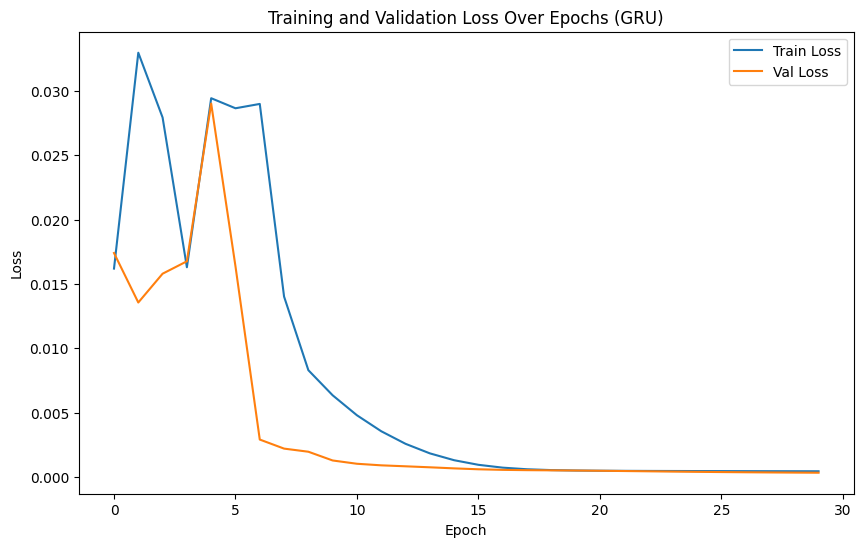

In [ ]:
# ---------------------------------------
# 9. Retrain Final Model with Best Hyperparams
# ---------------------------------------
best_params = study.best_params
model = GRUModel(input_dim=len(features), hidden_dim=best_params['hidden_dim'], output_dim=len(features)).to(device)
criterion = AsymmetricLoss(ratio=best_params['asymmetric_ratio'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

best_state, _, train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
model.load_state_dict(best_state)

# Plot training vs validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicted (first 5):
 [[783.4737  790.8761  774.7567  780.8692 ]
 [784.52124 792.51495 774.9361  789.44086]
 [788.4158  796.90894 778.09564 794.1977 ]
 [790.6281  799.27344 780.8405  798.96484]
 [798.1458  807.1276  787.33624 810.36884]]
Actual (first 5):
 [[778.81 789.63 775.8  786.14]
 [788.36 791.34 783.16 786.9 ]
 [786.08 794.48 785.02 794.02]
 [795.26 807.9  792.2  806.15]
 [806.4  809.97 802.83 806.65]]
Test MSE: 97.7681, RMSE: 9.8878, MAE: 7.5204


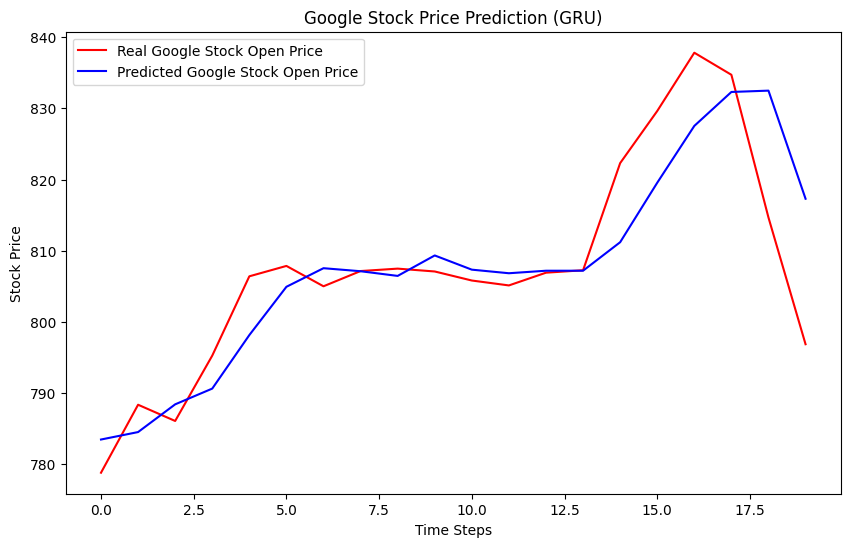

In [ ]:
# ---------------------------------------
# 10. Evaluate on Test Set
# ---------------------------------------
# Take the last N days of training plus test data to ensure proper alignment
test_input = np.concatenate((training_set[-N:], test_set), axis=0)
test_input_scaled = scaler.transform(test_input)

X_test = []
for i in range(N, len(test_input_scaled)):
    X_test.append(test_input_scaled[i-N:i, :])
X_test = np.array(X_test)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test_torch).cpu().numpy()

predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, len(features)))
real_prices = test_data[features].values

print("Predicted (first 5):\n", predicted_stock_price[:5])
print("Actual (first 5):\n", real_prices[:5])

# Compute Evaluation Metrics
mse = mean_squared_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Focus on 'Open' price for visualization
real_open_price = real_prices[:len(predicted_stock_price), 0]
predicted_open_price = predicted_stock_price[:, 0]

# Plot predicted vs real prices
plt.figure(figsize=(10,6))
plt.plot(real_open_price, color='red', label='Real Google Stock Open Price')
plt.plot(predicted_open_price, color='blue', label='Predicted Google Stock Open Price')
plt.title('Google Stock Price Prediction (GRU)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


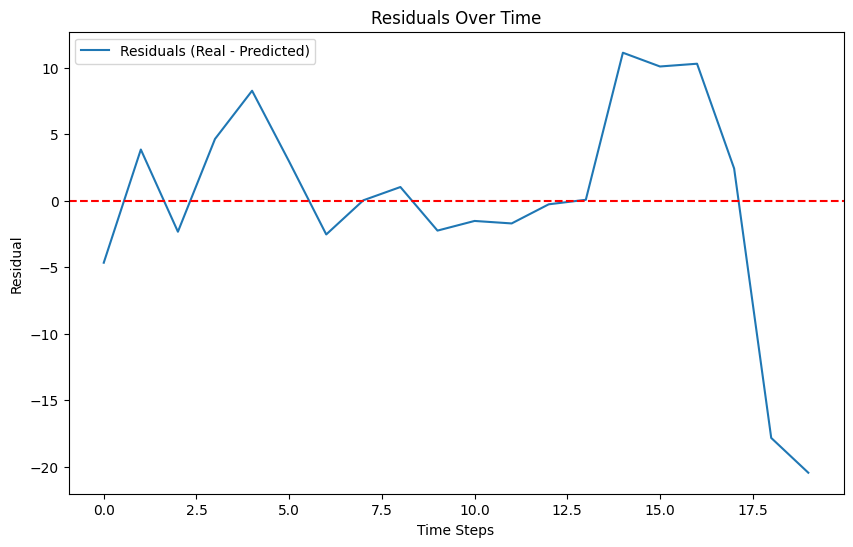

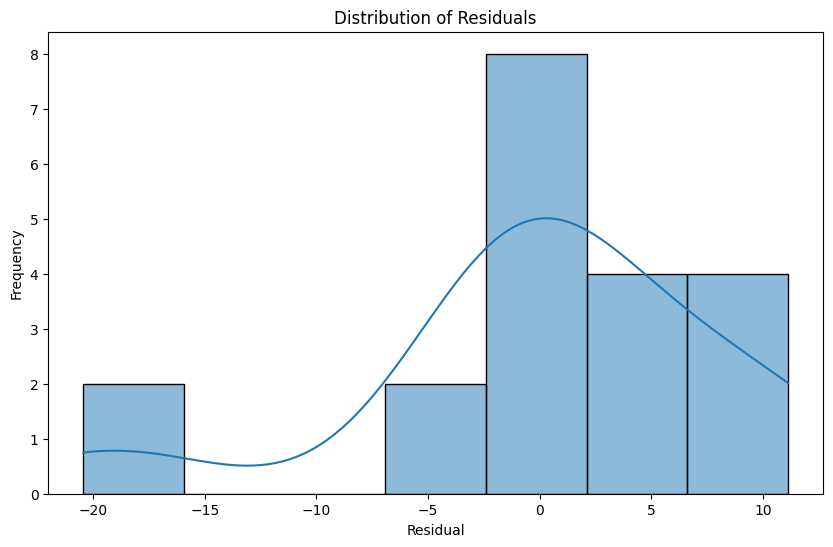

In [ ]:
# ---------------------------------------
# 11. Residual Analysis (Check for Systematic Bias)
# ---------------------------------------
residuals = real_open_price - predicted_open_price

# Plot residuals over time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals (Real - Predicted)')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

